In [1]:
from math import sqrt
from numpy import concatenate
import matplotlib.pyplot as plt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow.keras import optimizers
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error

### 데이터 불러오기

In [2]:
dataset=pd.read_csv('data/BTC-USD.csv',index_col=0)
dataset=dataset[['Close','Open','High','Low','Volume']].dropna(axis=0)
dataset

,Close,Open,High,Low,Volume
Date,,,,,
2020-04-16,7116.804199,6640.454102,7134.450684,6555.504395,4.678324e+10
2020-04-18,7257.665039,7092.291504,7269.956543,7089.247070,3.244719e+10
2020-04-19,7189.424805,7260.922363,7280.521973,7167.054688,3.131121e+10
2020-04-20,6881.958496,7186.873535,7240.290527,6835.502930,3.774711e+10
2020-04-21,6880.323242,6879.784180,6934.551758,6834.442383,3.258974e+10
...,...,...,...,...,...
2021-04-12,59893.453125,60175.945313,61253.035156,59589.875000,5.182869e+10
2021-04-13,63503.457031,59890.019531,63742.285156,59869.957031,6.998345e+10
2021-04-14,63109.695313,63523.753906,64863.097656,61554.796875,7.745178e+10


### LSTM 준비

In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i >= 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
#         else:
#             names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### 낮은 RMSE 찾기 위해 lag 조정

In [4]:
rmse_list=[]
n_features=5

for n_days in (3,6,12):

    values = dataset.values
    values = values.astype('float32')

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)

    reframed = series_to_supervised(scaled, n_days, 1)
    reframed2 = series_to_supervised(scaled, n_days, 1)

    drop_col = list(range(0,n_features*n_days,n_features))+list(range(n_features*n_days+1,n_features*(n_days+1)))

    reframed.drop(reframed.columns[drop_col], axis=1, inplace=True)

    values = reframed.values
    n_train_days = 180
    train = values[:n_train_days, :]
    test = values[n_train_days:, :]

    train_X, train_y = train[:, : -1], train[:, -1]    
    test_X, test_y = test[:, : -1], test[:, -1] 

    train_X = train_X.reshape((train_X.shape[0], n_days, n_features-1))
    test_X = test_X.reshape((test_X.shape[0], n_days, n_features-1))

    learning_rate=0.01
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='mae')

    history = model.fit(train_X, train_y, epochs=200, batch_size=16, validation_data=(test_X, test_y), verbose=2, shuffle=False)

    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], n_days*(n_features-1)))

    yhat=yhat[:,0]
    yhat=yhat.reshape(test_X.shape[0],1)

    inv_yhat = np.concatenate((yhat, reframed2.iloc[-(362-n_train_days-n_days):, -4:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]

    test_y=test_y.reshape(test_X.shape[0],1)
    inv_y = np.concatenate((test_y, reframed2.iloc[-(362-n_train_days-n_days):, -4:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]

    yhat=inv_yhat
    test_y=inv_y

    rmse = sqrt(mean_squared_error(test_y, yhat))
    rmse_list.append(round(rmse,3))

Epoch 1/200
12/12 - 10s - loss: 0.0205 - val_loss: 0.4153
Epoch 2/200
12/12 - 0s - loss: 0.0201 - val_loss: 0.3664
Epoch 3/200
12/12 - 0s - loss: 0.0360 - val_loss: 0.4139
Epoch 4/200
12/12 - 0s - loss: 0.0174 - val_loss: 0.3450
Epoch 5/200
12/12 - 0s - loss: 0.0207 - val_loss: 0.2905
Epoch 6/200
12/12 - 0s - loss: 0.0189 - val_loss: 0.2029
Epoch 7/200
12/12 - 0s - loss: 0.0169 - val_loss: 0.0721
Epoch 8/200
12/12 - 0s - loss: 0.0125 - val_loss: 0.0409
Epoch 9/200
12/12 - 0s - loss: 0.0121 - val_loss: 0.0351
Epoch 10/200
12/12 - 0s - loss: 0.0097 - val_loss: 0.0698
Epoch 11/200
12/12 - 0s - loss: 0.0093 - val_loss: 0.1449
Epoch 12/200
12/12 - 0s - loss: 0.0072 - val_loss: 0.1853
Epoch 13/200
12/12 - 0s - loss: 0.0054 - val_loss: 0.0901
Epoch 14/200
12/12 - 0s - loss: 0.0044 - val_loss: 0.0296
Epoch 15/200
12/12 - 0s - loss: 0.0061 - val_loss: 0.0334
Epoch 16/200
12/12 - 0s - loss: 0.0063 - val_loss: 0.0429
Epoch 17/200
12/12 - 0s - loss: 0.0083 - val_loss: 0.0659
Epoch 18/200
12/12 - 0

Epoch 142/200
12/12 - 0s - loss: 0.0101 - val_loss: 0.0325
Epoch 143/200
12/12 - 0s - loss: 0.0093 - val_loss: 0.0362
Epoch 144/200
12/12 - 0s - loss: 0.0044 - val_loss: 0.0349
Epoch 145/200
12/12 - 0s - loss: 0.0053 - val_loss: 0.0592
Epoch 146/200
12/12 - 0s - loss: 0.0045 - val_loss: 0.0908
Epoch 147/200
12/12 - 0s - loss: 0.0058 - val_loss: 0.0920
Epoch 148/200
12/12 - 0s - loss: 0.0072 - val_loss: 0.0796
Epoch 149/200
12/12 - 0s - loss: 0.0087 - val_loss: 0.0287
Epoch 150/200
12/12 - 0s - loss: 0.0080 - val_loss: 0.0682
Epoch 151/200
12/12 - 0s - loss: 0.0118 - val_loss: 0.0375
Epoch 152/200
12/12 - 0s - loss: 0.0076 - val_loss: 0.0471
Epoch 153/200
12/12 - 0s - loss: 0.0044 - val_loss: 0.0518
Epoch 154/200
12/12 - 0s - loss: 0.0039 - val_loss: 0.0521
Epoch 155/200
12/12 - 0s - loss: 0.0040 - val_loss: 0.0728
Epoch 156/200
12/12 - 0s - loss: 0.0046 - val_loss: 0.0690
Epoch 157/200
12/12 - 0s - loss: 0.0061 - val_loss: 0.0389
Epoch 158/200
12/12 - 0s - loss: 0.0060 - val_loss: 0.02

Epoch 83/200
12/12 - 0s - loss: 0.0092 - val_loss: 0.1641
Epoch 84/200
12/12 - 0s - loss: 0.0135 - val_loss: 0.1821
Epoch 85/200
12/12 - 0s - loss: 0.0119 - val_loss: 0.2405
Epoch 86/200
12/12 - 0s - loss: 0.0046 - val_loss: 0.2729
Epoch 87/200
12/12 - 0s - loss: 0.0054 - val_loss: 0.3023
Epoch 88/200
12/12 - 0s - loss: 0.0049 - val_loss: 0.3196
Epoch 89/200
12/12 - 0s - loss: 0.0044 - val_loss: 0.3248
Epoch 90/200
12/12 - 0s - loss: 0.0053 - val_loss: 0.3358
Epoch 91/200
12/12 - 0s - loss: 0.0052 - val_loss: 0.3313
Epoch 92/200
12/12 - 0s - loss: 0.0049 - val_loss: 0.3338
Epoch 93/200
12/12 - 0s - loss: 0.0048 - val_loss: 0.3142
Epoch 94/200
12/12 - 0s - loss: 0.0055 - val_loss: 0.2422
Epoch 95/200
12/12 - 0s - loss: 0.0116 - val_loss: 0.2625
Epoch 96/200
12/12 - 0s - loss: 0.0103 - val_loss: 0.3561
Epoch 97/200
12/12 - 0s - loss: 0.0044 - val_loss: 0.3665
Epoch 98/200
12/12 - 0s - loss: 0.0053 - val_loss: 0.3649
Epoch 99/200
12/12 - 0s - loss: 0.0038 - val_loss: 0.3646
Epoch 100/200


Epoch 23/200
12/12 - 0s - loss: 0.0055 - val_loss: 0.0274
Epoch 24/200
12/12 - 0s - loss: 0.0057 - val_loss: 0.0579
Epoch 25/200
12/12 - 0s - loss: 0.0052 - val_loss: 0.0259
Epoch 26/200
12/12 - 0s - loss: 0.0043 - val_loss: 0.0543
Epoch 27/200
12/12 - 0s - loss: 0.0066 - val_loss: 0.0467
Epoch 28/200
12/12 - 0s - loss: 0.0045 - val_loss: 0.0537
Epoch 29/200
12/12 - 0s - loss: 0.0061 - val_loss: 0.0333
Epoch 30/200
12/12 - 0s - loss: 0.0044 - val_loss: 0.0339
Epoch 31/200
12/12 - 0s - loss: 0.0063 - val_loss: 0.0631
Epoch 32/200
12/12 - 0s - loss: 0.0045 - val_loss: 0.0342
Epoch 33/200
12/12 - 0s - loss: 0.0046 - val_loss: 0.0776
Epoch 34/200
12/12 - 0s - loss: 0.0054 - val_loss: 0.0923
Epoch 35/200
12/12 - 0s - loss: 0.0101 - val_loss: 0.0303
Epoch 36/200
12/12 - 0s - loss: 0.0091 - val_loss: 0.0815
Epoch 37/200
12/12 - 0s - loss: 0.0070 - val_loss: 0.0322
Epoch 38/200
12/12 - 0s - loss: 0.0057 - val_loss: 0.0271
Epoch 39/200
12/12 - 0s - loss: 0.0047 - val_loss: 0.0438
Epoch 40/200
1

12/12 - 0s - loss: 0.0042 - val_loss: 0.0318
Epoch 164/200
12/12 - 0s - loss: 0.0050 - val_loss: 0.0316
Epoch 165/200
12/12 - 0s - loss: 0.0043 - val_loss: 0.0838
Epoch 166/200
12/12 - 0s - loss: 0.0039 - val_loss: 0.0312
Epoch 167/200
12/12 - 0s - loss: 0.0040 - val_loss: 0.0454
Epoch 168/200
12/12 - 0s - loss: 0.0052 - val_loss: 0.0817
Epoch 169/200
12/12 - 0s - loss: 0.0060 - val_loss: 0.1058
Epoch 170/200
12/12 - 0s - loss: 0.0124 - val_loss: 0.0574
Epoch 171/200
12/12 - 0s - loss: 0.0131 - val_loss: 0.0477
Epoch 172/200
12/12 - 0s - loss: 0.0082 - val_loss: 0.0925
Epoch 173/200
12/12 - 0s - loss: 0.0073 - val_loss: 0.1247
Epoch 174/200
12/12 - 0s - loss: 0.0070 - val_loss: 0.0322
Epoch 175/200
12/12 - 0s - loss: 0.0044 - val_loss: 0.0396
Epoch 176/200
12/12 - 0s - loss: 0.0045 - val_loss: 0.0642
Epoch 177/200
12/12 - 0s - loss: 0.0041 - val_loss: 0.0652
Epoch 178/200
12/12 - 0s - loss: 0.0039 - val_loss: 0.0310
Epoch 179/200
12/12 - 0s - loss: 0.0042 - val_loss: 0.0613
Epoch 180/2

In [5]:
rmse_list

[2491.957, 21677.568, 2323.568]

=> n_days = 12

### 낮은 RMSE 찾기 위해 epochs, batch_size 조정

In [6]:
rmse_list=[]
n_days=12

for i in (50, 100, 150, 200, 250):
    for j in (1, 8, 16, 64):
        values = dataset.values
        values = values.astype('float32')

        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled = scaler.fit_transform(values)

        reframed = series_to_supervised(scaled, n_days, 1)
        reframed2 = series_to_supervised(scaled, n_days, 1)

        drop_col = list(range(0,n_features*n_days,n_features))+list(range(n_features*n_days+1,n_features*(n_days+1)))

        reframed.drop(reframed.columns[drop_col], axis=1, inplace=True)

        values = reframed.values
        n_train_days = 180
        train = values[:n_train_days, :]
        test = values[n_train_days:, :]

        train_X, train_y = train[:, : -1], train[:, -1]    
        test_X, test_y = test[:, : -1], test[:, -1] 

        train_X = train_X.reshape((train_X.shape[0], n_days, n_features-1))
        test_X = test_X.reshape((test_X.shape[0], n_days, n_features-1))

        learning_rate=0.01
        model = Sequential()
        model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(1))
        model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='mae')

        history = model.fit(train_X, train_y, epochs=i, batch_size=j, validation_data=(test_X, test_y), verbose=2, shuffle=False)

        yhat = model.predict(test_X)
        test_X = test_X.reshape((test_X.shape[0], n_days*(n_features-1)))

        yhat=yhat[:,0]
        yhat=yhat.reshape(test_X.shape[0],1)

        inv_yhat = np.concatenate((yhat, reframed2.iloc[-(362-n_train_days-n_days):, -4:]), axis=1)
        inv_yhat = scaler.inverse_transform(inv_yhat)
        inv_yhat = inv_yhat[:,0]

        test_y=test_y.reshape(test_X.shape[0],1)
        inv_y = np.concatenate((test_y, reframed2.iloc[-(362-n_train_days-n_days):, -4:]), axis=1)
        inv_y = scaler.inverse_transform(inv_y)
        inv_y = inv_y[:,0]

        yhat=inv_yhat
        test_y=inv_y

        rmse = sqrt(mean_squared_error(test_y, yhat))
        rmse_list.append(round(rmse,3))

Epoch 1/50
180/180 - 5s - loss: 0.0114 - val_loss: 0.3766
Epoch 2/50
180/180 - 1s - loss: 0.0108 - val_loss: 0.4045
Epoch 3/50
180/180 - 1s - loss: 0.0102 - val_loss: 0.4011
Epoch 4/50
180/180 - 1s - loss: 0.0126 - val_loss: 0.4064
Epoch 5/50
180/180 - 1s - loss: 0.0128 - val_loss: 0.4068
Epoch 6/50
180/180 - 1s - loss: 0.0121 - val_loss: 0.4072
Epoch 7/50
180/180 - 1s - loss: 0.0119 - val_loss: 0.4073
Epoch 8/50
180/180 - 1s - loss: 0.0116 - val_loss: 0.4111
Epoch 9/50
180/180 - 1s - loss: 0.0124 - val_loss: 0.4073
Epoch 10/50
180/180 - 1s - loss: 0.0126 - val_loss: 0.4075
Epoch 11/50
180/180 - 1s - loss: 0.0116 - val_loss: 0.4075
Epoch 12/50
180/180 - 1s - loss: 0.0115 - val_loss: 0.4075
Epoch 13/50
180/180 - 1s - loss: 0.0125 - val_loss: 0.4075
Epoch 14/50
180/180 - 1s - loss: 0.0125 - val_loss: 0.4076
Epoch 15/50
180/180 - 1s - loss: 0.0124 - val_loss: 0.4077
Epoch 16/50
180/180 - 1s - loss: 0.0123 - val_loss: 0.4077
Epoch 17/50
180/180 - 1s - loss: 0.0123 - val_loss: 0.4077
Epoch 

Epoch 44/50
12/12 - 0s - loss: 0.0086 - val_loss: 0.0970
Epoch 45/50
12/12 - 0s - loss: 0.0100 - val_loss: 0.0639
Epoch 46/50
12/12 - 0s - loss: 0.0079 - val_loss: 0.0506
Epoch 47/50
12/12 - 0s - loss: 0.0061 - val_loss: 0.0616
Epoch 48/50
12/12 - 0s - loss: 0.0054 - val_loss: 0.0687
Epoch 49/50
12/12 - 0s - loss: 0.0049 - val_loss: 0.1045
Epoch 50/50
12/12 - 0s - loss: 0.0059 - val_loss: 0.0572
Epoch 1/50
3/3 - 5s - loss: 0.0398 - val_loss: 0.4617
Epoch 2/50
3/3 - 0s - loss: 0.0351 - val_loss: 0.4047
Epoch 3/50
3/3 - 0s - loss: 0.0173 - val_loss: 0.3503
Epoch 4/50
3/3 - 0s - loss: 0.0217 - val_loss: 0.3565
Epoch 5/50
3/3 - 0s - loss: 0.0138 - val_loss: 0.3079
Epoch 6/50
3/3 - 0s - loss: 0.0100 - val_loss: 0.2445
Epoch 7/50
3/3 - 0s - loss: 0.0116 - val_loss: 0.1921
Epoch 8/50
3/3 - 0s - loss: 0.0081 - val_loss: 0.1351
Epoch 9/50
3/3 - 0s - loss: 0.0089 - val_loss: 0.1266
Epoch 10/50
3/3 - 0s - loss: 0.0069 - val_loss: 0.1236
Epoch 11/50
3/3 - 0s - loss: 0.0063 - val_loss: 0.1003
Epoch

Epoch 86/100
180/180 - 1s - loss: 0.0102 - val_loss: 0.4049
Epoch 87/100
180/180 - 1s - loss: 0.0104 - val_loss: 0.4101
Epoch 88/100
180/180 - 1s - loss: 0.0091 - val_loss: 0.4052
Epoch 89/100
180/180 - 1s - loss: 0.0089 - val_loss: 0.4058
Epoch 90/100
180/180 - 1s - loss: 0.0089 - val_loss: 0.4049
Epoch 91/100
180/180 - 1s - loss: 0.0102 - val_loss: 0.4057
Epoch 92/100
180/180 - 1s - loss: 0.0101 - val_loss: 0.4049
Epoch 93/100
180/180 - 1s - loss: 0.0085 - val_loss: 0.4058
Epoch 94/100
180/180 - 1s - loss: 0.0090 - val_loss: 0.4058
Epoch 95/100
180/180 - 1s - loss: 0.0091 - val_loss: 0.4107
Epoch 96/100
180/180 - 1s - loss: 0.0110 - val_loss: 0.4096
Epoch 97/100
180/180 - 1s - loss: 0.0110 - val_loss: 0.4088
Epoch 98/100
180/180 - 1s - loss: 0.0108 - val_loss: 0.4095
Epoch 99/100
180/180 - 1s - loss: 0.0112 - val_loss: 0.4118
Epoch 100/100
180/180 - 1s - loss: 0.0110 - val_loss: 0.4118
Epoch 1/100
23/23 - 5s - loss: 0.0280 - val_loss: 0.4109
Epoch 2/100
23/23 - 0s - loss: 0.0157 - va

12/12 - 0s - loss: 0.0067 - val_loss: 0.0361
Epoch 28/100
12/12 - 0s - loss: 0.0053 - val_loss: 0.0384
Epoch 29/100
12/12 - 0s - loss: 0.0049 - val_loss: 0.0653
Epoch 30/100
12/12 - 0s - loss: 0.0072 - val_loss: 0.0309
Epoch 31/100
12/12 - 0s - loss: 0.0052 - val_loss: 0.0479
Epoch 32/100
12/12 - 0s - loss: 0.0047 - val_loss: 0.0967
Epoch 33/100
12/12 - 0s - loss: 0.0061 - val_loss: 0.0435
Epoch 34/100
12/12 - 0s - loss: 0.0059 - val_loss: 0.0483
Epoch 35/100
12/12 - 0s - loss: 0.0060 - val_loss: 0.0709
Epoch 36/100
12/12 - 0s - loss: 0.0064 - val_loss: 0.0790
Epoch 37/100
12/12 - 0s - loss: 0.0064 - val_loss: 0.0941
Epoch 38/100
12/12 - 0s - loss: 0.0101 - val_loss: 0.0668
Epoch 39/100
12/12 - 0s - loss: 0.0130 - val_loss: 0.0583
Epoch 40/100
12/12 - 0s - loss: 0.0060 - val_loss: 0.1094
Epoch 41/100
12/12 - 0s - loss: 0.0061 - val_loss: 0.1221
Epoch 42/100
12/12 - 0s - loss: 0.0073 - val_loss: 0.1061
Epoch 43/100
12/12 - 0s - loss: 0.0098 - val_loss: 0.0742
Epoch 44/100
12/12 - 0s - l

3/3 - 0s - loss: 0.0058 - val_loss: 0.0335
Epoch 72/100
3/3 - 0s - loss: 0.0039 - val_loss: 0.0390
Epoch 73/100
3/3 - 0s - loss: 0.0039 - val_loss: 0.0457
Epoch 74/100
3/3 - 0s - loss: 0.0049 - val_loss: 0.0474
Epoch 75/100
3/3 - 0s - loss: 0.0043 - val_loss: 0.0470
Epoch 76/100
3/3 - 0s - loss: 0.0040 - val_loss: 0.0383
Epoch 77/100
3/3 - 0s - loss: 0.0044 - val_loss: 0.0368
Epoch 78/100
3/3 - 0s - loss: 0.0054 - val_loss: 0.0346
Epoch 79/100
3/3 - 0s - loss: 0.0037 - val_loss: 0.0449
Epoch 80/100
3/3 - 0s - loss: 0.0039 - val_loss: 0.0568
Epoch 81/100
3/3 - 0s - loss: 0.0044 - val_loss: 0.0665
Epoch 82/100
3/3 - 0s - loss: 0.0043 - val_loss: 0.0591
Epoch 83/100
3/3 - 0s - loss: 0.0047 - val_loss: 0.0433
Epoch 84/100
3/3 - 0s - loss: 0.0048 - val_loss: 0.0324
Epoch 85/100
3/3 - 0s - loss: 0.0049 - val_loss: 0.0325
Epoch 86/100
3/3 - 0s - loss: 0.0037 - val_loss: 0.0498
Epoch 87/100
3/3 - 0s - loss: 0.0043 - val_loss: 0.0660
Epoch 88/100
3/3 - 0s - loss: 0.0042 - val_loss: 0.0670
Epoch

Epoch 110/150
180/180 - 1s - loss: 0.0112 - val_loss: 0.4054
Epoch 111/150
180/180 - 1s - loss: 0.0107 - val_loss: 0.4137
Epoch 112/150
180/180 - 1s - loss: 0.0100 - val_loss: 0.4151
Epoch 113/150
180/180 - 1s - loss: 0.0112 - val_loss: 0.4178
Epoch 114/150
180/180 - 1s - loss: 0.0086 - val_loss: 0.4122
Epoch 115/150
180/180 - 1s - loss: 0.0104 - val_loss: 0.4152
Epoch 116/150
180/180 - 1s - loss: 0.0099 - val_loss: 0.4102
Epoch 117/150
180/180 - 1s - loss: 0.0103 - val_loss: 0.4105
Epoch 118/150
180/180 - 1s - loss: 0.0137 - val_loss: 0.4029
Epoch 119/150
180/180 - 1s - loss: 0.0103 - val_loss: 0.4052
Epoch 120/150
180/180 - 1s - loss: 0.0122 - val_loss: 0.4087
Epoch 121/150
180/180 - 1s - loss: 0.0119 - val_loss: 0.4055
Epoch 122/150
180/180 - 1s - loss: 0.0105 - val_loss: 0.4137
Epoch 123/150
180/180 - 1s - loss: 0.0111 - val_loss: 0.4088
Epoch 124/150
180/180 - 1s - loss: 0.0095 - val_loss: 0.4121
Epoch 125/150
180/180 - 1s - loss: 0.0168 - val_loss: 0.4044
Epoch 126/150
180/180 - 

Epoch 100/150
23/23 - 0s - loss: 0.0072 - val_loss: 0.2339
Epoch 101/150
23/23 - 0s - loss: 0.0048 - val_loss: 0.2220
Epoch 102/150
23/23 - 0s - loss: 0.0090 - val_loss: 0.1591
Epoch 103/150
23/23 - 0s - loss: 0.0066 - val_loss: 0.2251
Epoch 104/150
23/23 - 0s - loss: 0.0047 - val_loss: 0.2033
Epoch 105/150
23/23 - 0s - loss: 0.0088 - val_loss: 0.1230
Epoch 106/150
23/23 - 0s - loss: 0.0070 - val_loss: 0.1946
Epoch 107/150
23/23 - 0s - loss: 0.0057 - val_loss: 0.1315
Epoch 108/150
23/23 - 0s - loss: 0.0086 - val_loss: 0.0951
Epoch 109/150
23/23 - 0s - loss: 0.0060 - val_loss: 0.1567
Epoch 110/150
23/23 - 0s - loss: 0.0048 - val_loss: 0.1231
Epoch 111/150
23/23 - 0s - loss: 0.0060 - val_loss: 0.0723
Epoch 112/150
23/23 - 0s - loss: 0.0085 - val_loss: 0.0300
Epoch 113/150
23/23 - 0s - loss: 0.0068 - val_loss: 0.0952
Epoch 114/150
23/23 - 0s - loss: 0.0045 - val_loss: 0.1425
Epoch 115/150
23/23 - 0s - loss: 0.0065 - val_loss: 0.1161
Epoch 116/150
23/23 - 0s - loss: 0.0091 - val_loss: 0.03

Epoch 91/150
12/12 - 0s - loss: 0.0082 - val_loss: 0.0312
Epoch 92/150
12/12 - 0s - loss: 0.0057 - val_loss: 0.0263
Epoch 93/150
12/12 - 0s - loss: 0.0058 - val_loss: 0.0253
Epoch 94/150
12/12 - 0s - loss: 0.0055 - val_loss: 0.0249
Epoch 95/150
12/12 - 0s - loss: 0.0050 - val_loss: 0.0348
Epoch 96/150
12/12 - 0s - loss: 0.0050 - val_loss: 0.0301
Epoch 97/150
12/12 - 0s - loss: 0.0046 - val_loss: 0.0241
Epoch 98/150
12/12 - 0s - loss: 0.0039 - val_loss: 0.0241
Epoch 99/150
12/12 - 0s - loss: 0.0039 - val_loss: 0.0340
Epoch 100/150
12/12 - 0s - loss: 0.0048 - val_loss: 0.0484
Epoch 101/150
12/12 - 0s - loss: 0.0040 - val_loss: 0.0253
Epoch 102/150
12/12 - 0s - loss: 0.0046 - val_loss: 0.0242
Epoch 103/150
12/12 - 0s - loss: 0.0041 - val_loss: 0.0334
Epoch 104/150
12/12 - 0s - loss: 0.0052 - val_loss: 0.0532
Epoch 105/150
12/12 - 0s - loss: 0.0040 - val_loss: 0.0256
Epoch 106/150
12/12 - 0s - loss: 0.0042 - val_loss: 0.0351
Epoch 107/150
12/12 - 0s - loss: 0.0043 - val_loss: 0.0675
Epoch 

Epoch 85/150
3/3 - 0s - loss: 0.0041 - val_loss: 0.0459
Epoch 86/150
3/3 - 0s - loss: 0.0040 - val_loss: 0.0434
Epoch 87/150
3/3 - 0s - loss: 0.0039 - val_loss: 0.0453
Epoch 88/150
3/3 - 0s - loss: 0.0040 - val_loss: 0.0488
Epoch 89/150
3/3 - 0s - loss: 0.0039 - val_loss: 0.0522
Epoch 90/150
3/3 - 0s - loss: 0.0039 - val_loss: 0.0524
Epoch 91/150
3/3 - 0s - loss: 0.0039 - val_loss: 0.0499
Epoch 92/150
3/3 - 0s - loss: 0.0039 - val_loss: 0.0476
Epoch 93/150
3/3 - 0s - loss: 0.0039 - val_loss: 0.0466
Epoch 94/150
3/3 - 0s - loss: 0.0040 - val_loss: 0.0487
Epoch 95/150
3/3 - 0s - loss: 0.0039 - val_loss: 0.0512
Epoch 96/150
3/3 - 0s - loss: 0.0039 - val_loss: 0.0511
Epoch 97/150
3/3 - 0s - loss: 0.0040 - val_loss: 0.0456
Epoch 98/150
3/3 - 0s - loss: 0.0038 - val_loss: 0.0430
Epoch 99/150
3/3 - 0s - loss: 0.0039 - val_loss: 0.0411
Epoch 100/150
3/3 - 0s - loss: 0.0039 - val_loss: 0.0440
Epoch 101/150
3/3 - 0s - loss: 0.0038 - val_loss: 0.0477
Epoch 102/150
3/3 - 0s - loss: 0.0038 - val_lo

Epoch 76/200
180/180 - 1s - loss: 0.0100 - val_loss: 0.4130
Epoch 77/200
180/180 - 1s - loss: 0.0087 - val_loss: 0.4045
Epoch 78/200
180/180 - 1s - loss: 0.0098 - val_loss: 0.4130
Epoch 79/200
180/180 - 1s - loss: 0.0087 - val_loss: 0.4045
Epoch 80/200
180/180 - 1s - loss: 0.0101 - val_loss: 0.4130
Epoch 81/200
180/180 - 1s - loss: 0.0097 - val_loss: 0.4011
Epoch 82/200
180/180 - 1s - loss: 0.0087 - val_loss: 0.4012
Epoch 83/200
180/180 - 1s - loss: 0.0102 - val_loss: 0.4013
Epoch 84/200
180/180 - 1s - loss: 0.0103 - val_loss: 0.4012
Epoch 85/200
180/180 - 1s - loss: 0.0092 - val_loss: 0.4012
Epoch 86/200
180/180 - 1s - loss: 0.0094 - val_loss: 0.4099
Epoch 87/200
180/180 - 1s - loss: 0.0102 - val_loss: 0.4088
Epoch 88/200
180/180 - 1s - loss: 0.0100 - val_loss: 0.4105
Epoch 89/200
180/180 - 1s - loss: 0.0095 - val_loss: 0.4099
Epoch 90/200
180/180 - 1s - loss: 0.0102 - val_loss: 0.4075
Epoch 91/200
180/180 - 1s - loss: 0.0109 - val_loss: 0.4088
Epoch 92/200
180/180 - 1s - loss: 0.0107

Epoch 12/200
23/23 - 0s - loss: 0.0135 - val_loss: 0.2743
Epoch 13/200
23/23 - 0s - loss: 0.0085 - val_loss: 0.2849
Epoch 14/200
23/23 - 0s - loss: 0.0170 - val_loss: 0.2173
Epoch 15/200
23/23 - 0s - loss: 0.0179 - val_loss: 0.2500
Epoch 16/200
23/23 - 0s - loss: 0.0114 - val_loss: 0.2355
Epoch 17/200
23/23 - 0s - loss: 0.0127 - val_loss: 0.2137
Epoch 18/200
23/23 - 0s - loss: 0.0092 - val_loss: 0.2756
Epoch 19/200
23/23 - 0s - loss: 0.0156 - val_loss: 0.2259
Epoch 20/200
23/23 - 0s - loss: 0.0195 - val_loss: 0.1582
Epoch 21/200
23/23 - 0s - loss: 0.0085 - val_loss: 0.2615
Epoch 22/200
23/23 - 0s - loss: 0.0150 - val_loss: 0.2069
Epoch 23/200
23/23 - 0s - loss: 0.0193 - val_loss: 0.1342
Epoch 24/200
23/23 - 0s - loss: 0.0110 - val_loss: 0.2378
Epoch 25/200
23/23 - 0s - loss: 0.0111 - val_loss: 0.1929
Epoch 26/200
23/23 - 0s - loss: 0.0128 - val_loss: 0.2109
Epoch 27/200
23/23 - 0s - loss: 0.0131 - val_loss: 0.2285
Epoch 28/200
23/23 - 0s - loss: 0.0110 - val_loss: 0.2489
Epoch 29/200
2

Epoch 153/200
23/23 - 0s - loss: 0.0052 - val_loss: 0.0765
Epoch 154/200
23/23 - 0s - loss: 0.0081 - val_loss: 0.0588
Epoch 155/200
23/23 - 0s - loss: 0.0071 - val_loss: 0.0289
Epoch 156/200
23/23 - 0s - loss: 0.0057 - val_loss: 0.0284
Epoch 157/200
23/23 - 0s - loss: 0.0043 - val_loss: 0.0309
Epoch 158/200
23/23 - 0s - loss: 0.0047 - val_loss: 0.0449
Epoch 159/200
23/23 - 0s - loss: 0.0092 - val_loss: 0.0852
Epoch 160/200
23/23 - 0s - loss: 0.0068 - val_loss: 0.0367
Epoch 161/200
23/23 - 0s - loss: 0.0058 - val_loss: 0.0301
Epoch 162/200
23/23 - 0s - loss: 0.0039 - val_loss: 0.0277
Epoch 163/200
23/23 - 0s - loss: 0.0046 - val_loss: 0.0597
Epoch 164/200
23/23 - 0s - loss: 0.0087 - val_loss: 0.0622
Epoch 165/200
23/23 - 0s - loss: 0.0064 - val_loss: 0.0287
Epoch 166/200
23/23 - 0s - loss: 0.0040 - val_loss: 0.0346
Epoch 167/200
23/23 - 0s - loss: 0.0060 - val_loss: 0.0451
Epoch 168/200
23/23 - 0s - loss: 0.0108 - val_loss: 0.1300
Epoch 169/200
23/23 - 0s - loss: 0.0057 - val_loss: 0.02

Epoch 94/200
12/12 - 0s - loss: 0.0055 - val_loss: 0.0397
Epoch 95/200
12/12 - 0s - loss: 0.0045 - val_loss: 0.0357
Epoch 96/200
12/12 - 0s - loss: 0.0042 - val_loss: 0.0547
Epoch 97/200
12/12 - 0s - loss: 0.0050 - val_loss: 0.0375
Epoch 98/200
12/12 - 0s - loss: 0.0042 - val_loss: 0.0444
Epoch 99/200
12/12 - 0s - loss: 0.0041 - val_loss: 0.0665
Epoch 100/200
12/12 - 0s - loss: 0.0041 - val_loss: 0.0956
Epoch 101/200
12/12 - 0s - loss: 0.0041 - val_loss: 0.0658
Epoch 102/200
12/12 - 0s - loss: 0.0045 - val_loss: 0.0693
Epoch 103/200
12/12 - 0s - loss: 0.0041 - val_loss: 0.0878
Epoch 104/200
12/12 - 0s - loss: 0.0049 - val_loss: 0.0479
Epoch 105/200
12/12 - 0s - loss: 0.0043 - val_loss: 0.0691
Epoch 106/200
12/12 - 0s - loss: 0.0047 - val_loss: 0.1002
Epoch 107/200
12/12 - 0s - loss: 0.0053 - val_loss: 0.1185
Epoch 108/200
12/12 - 0s - loss: 0.0082 - val_loss: 0.0955
Epoch 109/200
12/12 - 0s - loss: 0.0113 - val_loss: 0.0577
Epoch 110/200
12/12 - 0s - loss: 0.0102 - val_loss: 0.0426
Epo

Epoch 35/200
3/3 - 0s - loss: 0.0046 - val_loss: 0.0592
Epoch 36/200
3/3 - 0s - loss: 0.0046 - val_loss: 0.0555
Epoch 37/200
3/3 - 0s - loss: 0.0053 - val_loss: 0.0489
Epoch 38/200
3/3 - 0s - loss: 0.0042 - val_loss: 0.0539
Epoch 39/200
3/3 - 0s - loss: 0.0047 - val_loss: 0.0614
Epoch 40/200
3/3 - 0s - loss: 0.0052 - val_loss: 0.0584
Epoch 41/200
3/3 - 0s - loss: 0.0042 - val_loss: 0.0645
Epoch 42/200
3/3 - 0s - loss: 0.0044 - val_loss: 0.0662
Epoch 43/200
3/3 - 0s - loss: 0.0048 - val_loss: 0.0652
Epoch 44/200
3/3 - 0s - loss: 0.0042 - val_loss: 0.0695
Epoch 45/200
3/3 - 0s - loss: 0.0042 - val_loss: 0.0682
Epoch 46/200
3/3 - 0s - loss: 0.0042 - val_loss: 0.0693
Epoch 47/200
3/3 - 0s - loss: 0.0042 - val_loss: 0.0716
Epoch 48/200
3/3 - 0s - loss: 0.0042 - val_loss: 0.0703
Epoch 49/200
3/3 - 0s - loss: 0.0040 - val_loss: 0.0661
Epoch 50/200
3/3 - 0s - loss: 0.0041 - val_loss: 0.0620
Epoch 51/200
3/3 - 0s - loss: 0.0044 - val_loss: 0.0635
Epoch 52/200
3/3 - 0s - loss: 0.0053 - val_loss:

Epoch 180/200
3/3 - 0s - loss: 0.0033 - val_loss: 0.0494
Epoch 181/200
3/3 - 0s - loss: 0.0035 - val_loss: 0.0506
Epoch 182/200
3/3 - 0s - loss: 0.0035 - val_loss: 0.0469
Epoch 183/200
3/3 - 0s - loss: 0.0035 - val_loss: 0.0471
Epoch 184/200
3/3 - 0s - loss: 0.0038 - val_loss: 0.0454
Epoch 185/200
3/3 - 0s - loss: 0.0034 - val_loss: 0.0444
Epoch 186/200
3/3 - 0s - loss: 0.0036 - val_loss: 0.0427
Epoch 187/200
3/3 - 0s - loss: 0.0037 - val_loss: 0.0454
Epoch 188/200
3/3 - 0s - loss: 0.0043 - val_loss: 0.0429
Epoch 189/200
3/3 - 0s - loss: 0.0035 - val_loss: 0.0449
Epoch 190/200
3/3 - 0s - loss: 0.0035 - val_loss: 0.0432
Epoch 191/200
3/3 - 0s - loss: 0.0036 - val_loss: 0.0457
Epoch 192/200
3/3 - 0s - loss: 0.0038 - val_loss: 0.0488
Epoch 193/200
3/3 - 0s - loss: 0.0034 - val_loss: 0.0517
Epoch 194/200
3/3 - 0s - loss: 0.0038 - val_loss: 0.0514
Epoch 195/200
3/3 - 0s - loss: 0.0036 - val_loss: 0.0486
Epoch 196/200
3/3 - 0s - loss: 0.0040 - val_loss: 0.0471
Epoch 197/200
3/3 - 0s - loss: 

Epoch 118/250
180/180 - 1s - loss: 0.0240 - val_loss: 0.4423
Epoch 119/250
180/180 - 1s - loss: 0.0207 - val_loss: 0.4223
Epoch 120/250
180/180 - 1s - loss: 0.0252 - val_loss: 0.4253
Epoch 121/250
180/180 - 1s - loss: 0.0197 - val_loss: 0.4397
Epoch 122/250
180/180 - 1s - loss: 0.0225 - val_loss: 0.4252
Epoch 123/250
180/180 - 1s - loss: 0.0211 - val_loss: 0.4004
Epoch 124/250
180/180 - 1s - loss: 0.0159 - val_loss: 0.4004
Epoch 125/250
180/180 - 1s - loss: 0.0133 - val_loss: 0.4004
Epoch 126/250
180/180 - 1s - loss: 0.0129 - val_loss: 0.4003
Epoch 127/250
180/180 - 1s - loss: 0.0128 - val_loss: 0.4004
Epoch 128/250
180/180 - 1s - loss: 0.0129 - val_loss: 0.4004
Epoch 129/250
180/180 - 1s - loss: 0.0133 - val_loss: 0.4004
Epoch 130/250
180/180 - 1s - loss: 0.0107 - val_loss: 0.3999
Epoch 131/250
180/180 - 1s - loss: 0.0196 - val_loss: 0.4229
Epoch 132/250
180/180 - 1s - loss: 0.0176 - val_loss: 0.4061
Epoch 133/250
180/180 - 1s - loss: 0.0182 - val_loss: 0.4034
Epoch 134/250
180/180 - 

Epoch 3/250
23/23 - 0s - loss: 0.0129 - val_loss: 0.3302
Epoch 4/250
23/23 - 0s - loss: 0.0130 - val_loss: 0.3219
Epoch 5/250
23/23 - 0s - loss: 0.0107 - val_loss: 0.3435
Epoch 6/250
23/23 - 0s - loss: 0.0144 - val_loss: 0.2788
Epoch 7/250
23/23 - 0s - loss: 0.0189 - val_loss: 0.3326
Epoch 8/250
23/23 - 0s - loss: 0.0119 - val_loss: 0.3307
Epoch 9/250
23/23 - 0s - loss: 0.0121 - val_loss: 0.3080
Epoch 10/250
23/23 - 0s - loss: 0.0109 - val_loss: 0.3121
Epoch 11/250
23/23 - 0s - loss: 0.0115 - val_loss: 0.2951
Epoch 12/250
23/23 - 0s - loss: 0.0097 - val_loss: 0.2875
Epoch 13/250
23/23 - 0s - loss: 0.0146 - val_loss: 0.2604
Epoch 14/250
23/23 - 0s - loss: 0.0155 - val_loss: 0.2730
Epoch 15/250
23/23 - 0s - loss: 0.0141 - val_loss: 0.2462
Epoch 16/250
23/23 - 0s - loss: 0.0145 - val_loss: 0.2562
Epoch 17/250
23/23 - 0s - loss: 0.0097 - val_loss: 0.2791
Epoch 18/250
23/23 - 0s - loss: 0.0166 - val_loss: 0.2497
Epoch 19/250
23/23 - 0s - loss: 0.0198 - val_loss: 0.1968
Epoch 20/250
23/23 - 

Epoch 144/250
23/23 - 0s - loss: 0.0047 - val_loss: 0.0549
Epoch 145/250
23/23 - 0s - loss: 0.0040 - val_loss: 0.0590
Epoch 146/250
23/23 - 0s - loss: 0.0039 - val_loss: 0.0466
Epoch 147/250
23/23 - 0s - loss: 0.0053 - val_loss: 0.0587
Epoch 148/250
23/23 - 0s - loss: 0.0084 - val_loss: 0.1492
Epoch 149/250
23/23 - 0s - loss: 0.0088 - val_loss: 0.0410
Epoch 150/250
23/23 - 0s - loss: 0.0060 - val_loss: 0.0334
Epoch 151/250
23/23 - 0s - loss: 0.0042 - val_loss: 0.0503
Epoch 152/250
23/23 - 0s - loss: 0.0054 - val_loss: 0.0736
Epoch 153/250
23/23 - 0s - loss: 0.0097 - val_loss: 0.1337
Epoch 154/250
23/23 - 0s - loss: 0.0067 - val_loss: 0.0478
Epoch 155/250
23/23 - 0s - loss: 0.0041 - val_loss: 0.0595
Epoch 156/250
23/23 - 0s - loss: 0.0051 - val_loss: 0.0846
Epoch 157/250
23/23 - 0s - loss: 0.0078 - val_loss: 0.1093
Epoch 158/250
23/23 - 0s - loss: 0.0074 - val_loss: 0.0591
Epoch 159/250
23/23 - 0s - loss: 0.0066 - val_loss: 0.0433
Epoch 160/250
23/23 - 0s - loss: 0.0042 - val_loss: 0.04

Epoch 34/250
12/12 - 0s - loss: 0.0058 - val_loss: 0.0750
Epoch 35/250
12/12 - 0s - loss: 0.0061 - val_loss: 0.0980
Epoch 36/250
12/12 - 0s - loss: 0.0090 - val_loss: 0.1020
Epoch 37/250
12/12 - 0s - loss: 0.0116 - val_loss: 0.0803
Epoch 38/250
12/12 - 0s - loss: 0.0120 - val_loss: 0.0413
Epoch 39/250
12/12 - 0s - loss: 0.0099 - val_loss: 0.0371
Epoch 40/250
12/12 - 0s - loss: 0.0055 - val_loss: 0.0859
Epoch 41/250
12/12 - 0s - loss: 0.0057 - val_loss: 0.0863
Epoch 42/250
12/12 - 0s - loss: 0.0056 - val_loss: 0.0472
Epoch 43/250
12/12 - 0s - loss: 0.0052 - val_loss: 0.0544
Epoch 44/250
12/12 - 0s - loss: 0.0044 - val_loss: 0.0955
Epoch 45/250
12/12 - 0s - loss: 0.0059 - val_loss: 0.0468
Epoch 46/250
12/12 - 0s - loss: 0.0045 - val_loss: 0.0682
Epoch 47/250
12/12 - 0s - loss: 0.0062 - val_loss: 0.0310
Epoch 48/250
12/12 - 0s - loss: 0.0053 - val_loss: 0.0316
Epoch 49/250
12/12 - 0s - loss: 0.0044 - val_loss: 0.0583
Epoch 50/250
12/12 - 0s - loss: 0.0058 - val_loss: 0.0270
Epoch 51/250
1

Epoch 174/250
12/12 - 0s - loss: 0.0040 - val_loss: 0.0938
Epoch 175/250
12/12 - 0s - loss: 0.0056 - val_loss: 0.0500
Epoch 176/250
12/12 - 0s - loss: 0.0050 - val_loss: 0.0511
Epoch 177/250
12/12 - 0s - loss: 0.0049 - val_loss: 0.0537
Epoch 178/250
12/12 - 0s - loss: 0.0043 - val_loss: 0.0656
Epoch 179/250
12/12 - 0s - loss: 0.0045 - val_loss: 0.0750
Epoch 180/250
12/12 - 0s - loss: 0.0039 - val_loss: 0.0926
Epoch 181/250
12/12 - 0s - loss: 0.0043 - val_loss: 0.0779
Epoch 182/250
12/12 - 0s - loss: 0.0040 - val_loss: 0.0893
Epoch 183/250
12/12 - 0s - loss: 0.0040 - val_loss: 0.1097
Epoch 184/250
12/12 - 0s - loss: 0.0053 - val_loss: 0.0672
Epoch 185/250
12/12 - 0s - loss: 0.0049 - val_loss: 0.0756
Epoch 186/250
12/12 - 0s - loss: 0.0040 - val_loss: 0.0952
Epoch 187/250
12/12 - 0s - loss: 0.0045 - val_loss: 0.0913
Epoch 188/250
12/12 - 0s - loss: 0.0041 - val_loss: 0.1024
Epoch 189/250
12/12 - 0s - loss: 0.0044 - val_loss: 0.1214
Epoch 190/250
12/12 - 0s - loss: 0.0057 - val_loss: 0.11

Epoch 67/250
3/3 - 0s - loss: 0.0041 - val_loss: 0.0346
Epoch 68/250
3/3 - 0s - loss: 0.0040 - val_loss: 0.0340
Epoch 69/250
3/3 - 0s - loss: 0.0045 - val_loss: 0.0327
Epoch 70/250
3/3 - 0s - loss: 0.0041 - val_loss: 0.0333
Epoch 71/250
3/3 - 0s - loss: 0.0040 - val_loss: 0.0284
Epoch 72/250
3/3 - 0s - loss: 0.0042 - val_loss: 0.0261
Epoch 73/250
3/3 - 0s - loss: 0.0050 - val_loss: 0.0260
Epoch 74/250
3/3 - 0s - loss: 0.0040 - val_loss: 0.0271
Epoch 75/250
3/3 - 0s - loss: 0.0042 - val_loss: 0.0357
Epoch 76/250
3/3 - 0s - loss: 0.0045 - val_loss: 0.0414
Epoch 77/250
3/3 - 0s - loss: 0.0045 - val_loss: 0.0350
Epoch 78/250
3/3 - 0s - loss: 0.0045 - val_loss: 0.0264
Epoch 79/250
3/3 - 0s - loss: 0.0049 - val_loss: 0.0257
Epoch 80/250
3/3 - 0s - loss: 0.0043 - val_loss: 0.0255
Epoch 81/250
3/3 - 0s - loss: 0.0040 - val_loss: 0.0315
Epoch 82/250
3/3 - 0s - loss: 0.0044 - val_loss: 0.0409
Epoch 83/250
3/3 - 0s - loss: 0.0042 - val_loss: 0.0399
Epoch 84/250
3/3 - 0s - loss: 0.0045 - val_loss:

Epoch 212/250
3/3 - 0s - loss: 0.0034 - val_loss: 0.0447
Epoch 213/250
3/3 - 0s - loss: 0.0036 - val_loss: 0.0456
Epoch 214/250
3/3 - 0s - loss: 0.0034 - val_loss: 0.0441
Epoch 215/250
3/3 - 0s - loss: 0.0037 - val_loss: 0.0406
Epoch 216/250
3/3 - 0s - loss: 0.0037 - val_loss: 0.0383
Epoch 217/250
3/3 - 0s - loss: 0.0042 - val_loss: 0.0354
Epoch 218/250
3/3 - 0s - loss: 0.0034 - val_loss: 0.0373
Epoch 219/250
3/3 - 0s - loss: 0.0035 - val_loss: 0.0397
Epoch 220/250
3/3 - 0s - loss: 0.0037 - val_loss: 0.0403
Epoch 221/250
3/3 - 0s - loss: 0.0034 - val_loss: 0.0427
Epoch 222/250
3/3 - 0s - loss: 0.0034 - val_loss: 0.0420
Epoch 223/250
3/3 - 0s - loss: 0.0036 - val_loss: 0.0393
Epoch 224/250
3/3 - 0s - loss: 0.0036 - val_loss: 0.0387
Epoch 225/250
3/3 - 0s - loss: 0.0041 - val_loss: 0.0372
Epoch 226/250
3/3 - 0s - loss: 0.0034 - val_loss: 0.0391
Epoch 227/250
3/3 - 0s - loss: 0.0035 - val_loss: 0.0393
Epoch 228/250
3/3 - 0s - loss: 0.0036 - val_loss: 0.0416
Epoch 229/250
3/3 - 0s - loss: 

In [7]:
rmse_list

[28157.208,
 19729.345,
 4566.275,
 4179.019,
 28327.04,
 9134.522,
 7206.344,
 4095.267,
 28137.442,
 4088.199,
 5369.298,
 3283.32,
 27673.274,
 4355.502,
 10050.705,
 3789.317,
 28235.931,
 17534.641,
 6600.282,
 3594.471]

In [8]:
min(rmse_list)

3283.32

In [9]:
divmod(rmse_list.index(min(rmse_list))+1,4)

(3, 0)

### 최종모델
n_days = 12  
epochs = 150  
batch_size = 64

In [15]:
values = dataset.values
values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, n_days, 1)
reframed2 = series_to_supervised(scaled, n_days, 1)

drop_col = list(range(0,n_features*n_days,n_features))+list(range(n_features*n_days+1,n_features*(n_days+1)))

reframed.drop(reframed.columns[drop_col], axis=1, inplace=True)

values = reframed.values
n_train_days = 180
train = values[:n_train_days, :]
test = values[n_train_days:, :]

train_X, train_y = train[:, : -1], train[:, -1]    
test_X, test_y = test[:, : -1], test[:, -1] 

train_X = train_X.reshape((train_X.shape[0], n_days, n_features-1))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features-1))

learning_rate=0.01
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='mae')

history = model.fit(train_X, train_y, epochs=150, batch_size=64, validation_data=(test_X, test_y), verbose=2, shuffle=False)

yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_days*(n_features-1)))

yhat=yhat[:,0]
yhat=yhat.reshape(test_X.shape[0],1)

inv_yhat = np.concatenate((yhat, reframed2.iloc[-(362-n_train_days-n_days):, -4:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

test_y=test_y.reshape(test_X.shape[0],1)
inv_y = np.concatenate((test_y, reframed2.iloc[-(362-n_train_days-n_days):, -4:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

yhat=inv_yhat
test_y=inv_y

Epoch 1/150
3/3 - 7s - loss: 0.0580 - val_loss: 0.3917
Epoch 2/150
3/3 - 0s - loss: 0.0407 - val_loss: 0.3920
Epoch 3/150
3/3 - 0s - loss: 0.0125 - val_loss: 0.3372
Epoch 4/150
3/3 - 0s - loss: 0.0200 - val_loss: 0.3418
Epoch 5/150
3/3 - 0s - loss: 0.0143 - val_loss: 0.3003
Epoch 6/150
3/3 - 0s - loss: 0.0101 - val_loss: 0.2388
Epoch 7/150
3/3 - 0s - loss: 0.0106 - val_loss: 0.1815
Epoch 8/150
3/3 - 0s - loss: 0.0075 - val_loss: 0.1116
Epoch 9/150
3/3 - 0s - loss: 0.0085 - val_loss: 0.0784
Epoch 10/150
3/3 - 0s - loss: 0.0079 - val_loss: 0.0816
Epoch 11/150
3/3 - 0s - loss: 0.0061 - val_loss: 0.0833
Epoch 12/150
3/3 - 0s - loss: 0.0060 - val_loss: 0.0789
Epoch 13/150
3/3 - 0s - loss: 0.0067 - val_loss: 0.0733
Epoch 14/150
3/3 - 0s - loss: 0.0056 - val_loss: 0.0517
Epoch 15/150
3/3 - 0s - loss: 0.0068 - val_loss: 0.0425
Epoch 16/150
3/3 - 0s - loss: 0.0061 - val_loss: 0.0384
Epoch 17/150
3/3 - 0s - loss: 0.0052 - val_loss: 0.0373
Epoch 18/150
3/3 - 0s - loss: 0.0052 - val_loss: 0.0341
E

Epoch 147/150
3/3 - 0s - loss: 0.0037 - val_loss: 0.0480
Epoch 148/150
3/3 - 0s - loss: 0.0037 - val_loss: 0.0398
Epoch 149/150
3/3 - 0s - loss: 0.0038 - val_loss: 0.0347
Epoch 150/150
3/3 - 0s - loss: 0.0040 - val_loss: 0.0340


### RMSE

In [16]:
rmse = sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2792.517


### loss plot

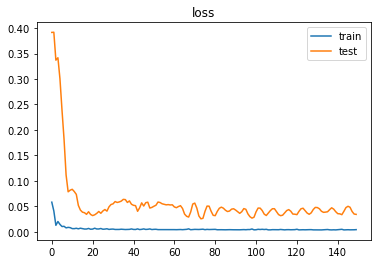

In [17]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title('loss')
plt.show()

### 예측 결과 plot

In [18]:
features=[yhat,test_y]

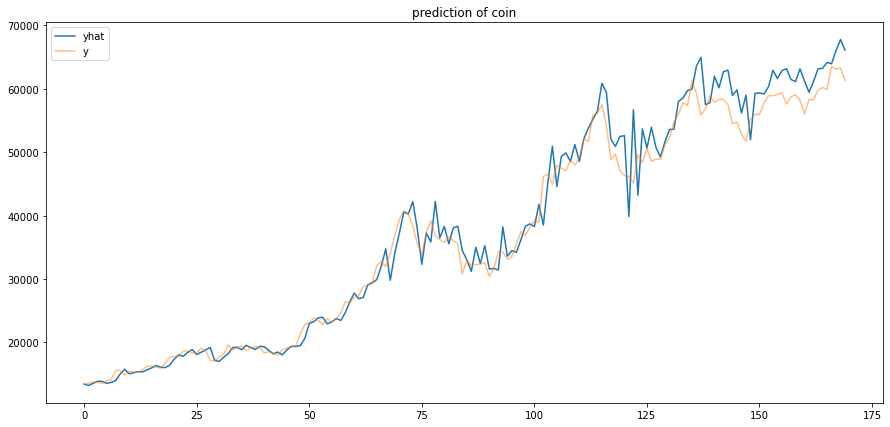

In [20]:
plt.figure(figsize=(15,7))
plt.title('prediction of coin')
plt.plot(yhat,label='yhat')
plt.plot(test_y,alpha=0.5,label='y')
plt.legend()
plt.show()